In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Music Genre Classification
In this notebook I tried to learn the basic concepts of neural networks and use it to classify the music files in dataset. Majorly this notebook can be divided into 3 parts:

   1) Using ANN

   2) Tackling overfitting with ANN

   3) Using CNN


Also to read the dataset I have used librosa library which only read files <1Mb and one file is greater than the size giving error due to which I have ignored it. The dataset contains the following genres, the keys being the prediction targets
    
    0: "disco",
    1: "metal",
    2: "reggae",
    3: "blues",
    4: "rock",
    5: "classical",
    6: "jazz",
    7: "hiphop",
    8: "country",
    9: "pop"


In [ ]:
!unzip -q "/content/drive/MyDrive/Data.zip" -d "/content/Data"

In [ ]:
pip install tensorflow

In [ ]:
import os
import librosa
import math
import json
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
dataset_path = r"/content/Data/genres_original"
json_path = r"data.json"
SAMPLE_RATE = 22050
DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

In [ ]:
def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048,
             hop_length=512, num_segments=5):
    # Data storage dictionary
    data = {
        "mapping": [],
        "mfcc": [],
        "labels": [],
    }
    samples_ps = int(SAMPLES_PER_TRACK/num_segments) # ps = per segment
    expected_vects_ps = math.ceil(samples_ps/hop_length)

    # loop through all the genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        # ensuring not at root
        if dirpath is not dataset_path:
            # save the semantic label
            dirpath_comp = dirpath.split("/")
            semantic_label = dirpath_comp[-1]
            data["mapping"].append(semantic_label)
            print(f"Processing: {semantic_label}")

            # process files for specific genre
            for f in filenames:
                if(f==str("jazz.00054.wav")):
                    # As librosa only read files <1Mb
                    continue
                else:
                    # load audio file
                    file_path = os.path.join(dirpath, f)
                    signal,sr = librosa.load(file_path,sr=SAMPLE_RATE)
                    for s in range(num_segments):
                        start_sample = samples_ps * s
                        finish_sample = start_sample + samples_ps

                        mfcc = librosa.feature.mfcc(
                                          y=signal[start_sample:finish_sample],
                                          sr=sr,
                                          n_fft=n_fft,
                                          n_mfcc=n_mfcc,
                                          hop_length=hop_length
                                      )


                        mfcc = mfcc.T

                        # store mfcc if it has expected length
                        if len(mfcc)==expected_vects_ps:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
                            print(f"{file_path}, segment: {s+1}")

    with open(json_path,"w") as f:
        json.dump(data,f,indent=4)

In [ ]:
from IPython.display import clear_output

In [ ]:
save_mfcc(dataset_path,json_path,num_segments=10)
clear_output()

In [ ]:
filepath = r"/content/Data/genres_original/blues/blues.0000"

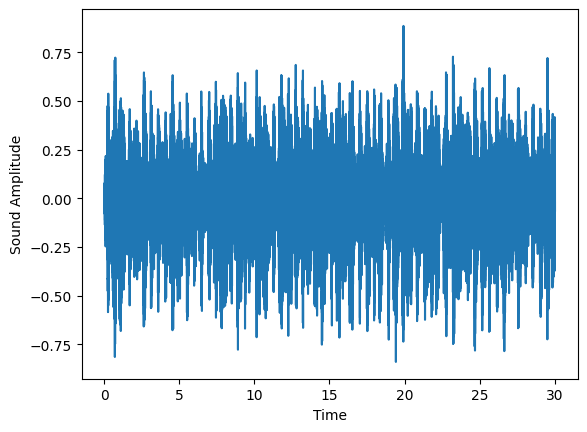

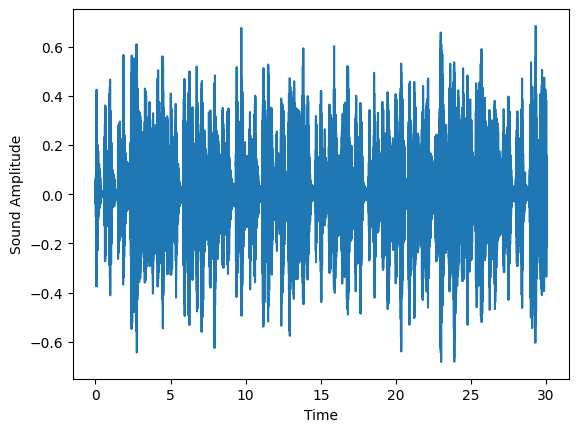

In [ ]:
for i in range(2):
    audio, sfreq = librosa.load(filepath+str(i)+".wav")
    time = np.arange(0, len(audio))/sfreq
    plt.plot(time,audio)
    plt.xlabel("Time")
    plt.ylabel("Sound Amplitude")
    plt.show()

# Classifier
This part uses the concepts of ANN with keras and sequential layers. I have also done splitting in the ratio 70:30

The model is Sequential and architecture only has Flatten and the Dense layers available in keras for the basic ANN representation. As it is naive model we can expect it to be overfit. Info on the layers can be found [here](https://machinelearningknowledge.ai/different-types-of-keras-layers-explained-for-beginners/)

In [ ]:
import json
import numpy as np

In [ ]:
# load data
def load_data(dataset_path):
    with open(dataset_path,"r") as f:
        data = json.load(f)

    # Convert list to numpy arrays
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])

    return inputs,targets

In [ ]:
inputs,targets = load_data(r"./data.json")ф

In [ ]:
# splitting the data
from sklearn.model_selection import train_test_split

input_train, input_test, target_train, target_test = train_test_split(inputs, targets, test_size=0.3)
print(input_train.shape, target_train.shape)

(6990, 130, 13) (6990,)


In [ ]:
from tensorflow import keras
from keras import Sequential
from keras.layers import *

In [ ]:
model = Sequential()

model.add(Flatten(input_shape=(inputs.shape[1],inputs.shape[2])))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 1690)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       865,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,014,218 (3.87 MB)

 Trainable params: 1,014,218 (3.87 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras import optimizers
adam = optimizers.Adam(learning_rate=1e-4)

In [ ]:
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

In [ ]:
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

hist = model.fit(input_train, target_train,
                 validation_data = (input_test,target_test),
                 epochs = 50,
                 batch_size = 32)
clear_output()

In [ ]:
def plot_history(hist):
    plt.figure(figsize=(20,15))
    fig, axs = plt.subplots(2)
    # accuracy subplot
    axs[0].plot(hist.history["accuracy"], label="train accuracy")
    axs[0].plot(hist.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # Error subplot
    axs[1].plot(hist.history["loss"], label="train error")
    axs[1].plot(hist.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

<Figure size 2000x1500 with 0 Axes>

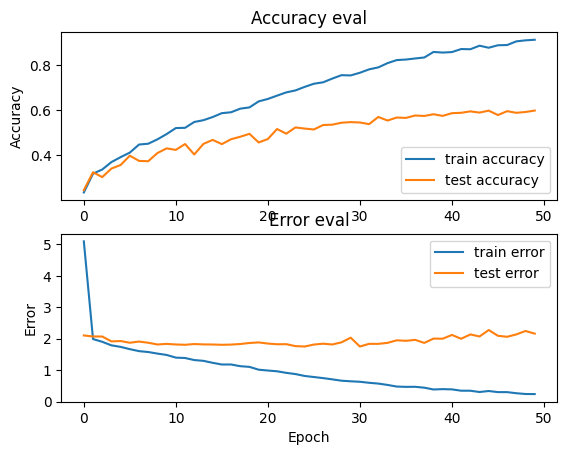

In [ ]:
plot_history(hist)

In [ ]:
test_error, test_accuracy = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6100 - loss: 2.1518
Test accuracy: 0.5991321802139282


# Overfitting
This part deals with the overfitting of the previous model. We can deal with it by majorly doing the following process.
- Making architecture less complicated
- Using augmented data
- Early stopping of training
- Adding dropout layers
- Regularization / Standardization  

I have added the dropout layers and kernel_regularizers as compared to previous naive model giving the dropout probability as 30%
Kernel_regularizers is one of the 3 type of regularizer used to impose penalties. More info can be found [here](https://medium.com/@robertjohn_15390/regularization-in-tensorflow-using-keras-api-48aba746ae21)

In [ ]:
import tensorflow.keras as keras

In [ ]:
# Overfitting
model = Sequential()

model.add(Flatten(input_shape=(inputs.shape[1],inputs.shape[2])))
model.add(Dense(512, activation='relu', kernel_regularizer = keras.regularizers.l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu', kernel_regularizer = keras.regularizers.l2(0.003)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer = keras.regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 1690)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       865,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,015,978 (3.88 MB)

 Trainable params: 1,015,978 (3.88 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras import optimizers
adam = optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=adam, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
hist = model.fit(input_train, target_train, validation_data=(input_test, target_test), epochs=50)

Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 27s 121ms/step - accuracy: 0.1394 - loss: 31.0833 - val_accuracy: 0.2206 - val_loss: 5.0595
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 38s 112ms/step - accuracy: 0.1684 - loss: 8.0611 - val_accuracy: 0.2350 - val_loss: 4.8895
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 24s 108ms/step - accuracy: 0.1681 - loss: 6.0875 - val_accuracy: 0.2490 - val_loss: 4.8097
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 24s 111ms/step - accuracy: 0.2049 - loss: 5.4076 - val_accuracy: 0.3024 - val_loss: 4.7982
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 39s 102ms/step - accuracy: 0.1871 - loss: 5.2723 - val_accuracy: 0.3188 - val_loss: 4.7477
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 23s 104ms/step - accuracy: 0.2165 - loss: 5.0420 - val_accuracy: 0.3361 - val_loss: 4.6289
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 24s 108ms/step - accuracy: 0.2323 - loss: 4.9215 - val_accuracy: 0.3385 - val_loss: 4.5962
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 23s 105ms/step - accuracy: 0.2610 - loss: 

<Figure size 2000x1500 with 0 Axes>

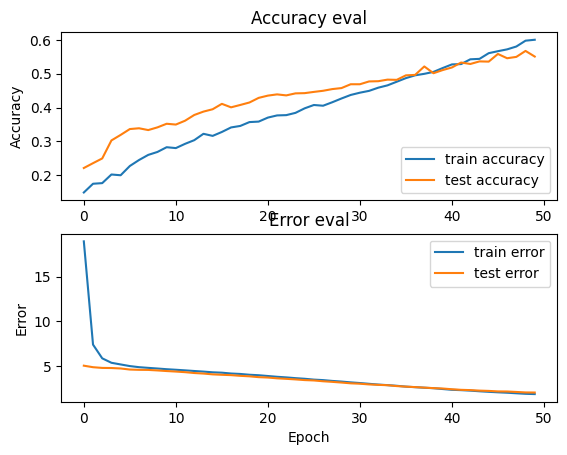

In [ ]:
plot_history(hist)

In [ ]:
test_error, test_accuracy = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5540 - loss: 2.0116
Test accuracy: 0.5510680675506592


In [ ]:
def prepare_dataset(test_size, validation_size):
    X,y = load_data(r"./data.json")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = validation_size)
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(0.25, 0.2)

In [ ]:
input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])
print(input_shape)

(130, 13, 1)


In [ ]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation = "relu", input_shape = input_shape))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (2, 2), activation = "relu"))
model.add(MaxPool2D((2, 2), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(16, (1, 1), activation = "relu"))
model.add(MaxPool2D((1, 1), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="softmax"))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 11, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 6, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 6, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 4, 32)      │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 2, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 31, 2, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 1, 32)      │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 1, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 1, 16)      │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 1, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 1, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,242 (129.85 KB)

 Trainable params: 32,954 (128.73 KB)

 Non-trainable params: 288 (1.12 KB)

In [ ]:
from tensorflow.keras import optimizers
adam = optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=adam,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

hist = model.fit(X_train, y_train,
                 validation_data = (X_val, y_val),
                 epochs = 70,
                 batch_size = 32)

Epoch 1/70
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.6586 - loss: 0.9818 - val_accuracy: 0.6262 - val_loss: 1.1377
Epoch 2/70
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6710 - loss: 0.9437 - val_accuracy: 0.6235 - val_loss: 1.1379
Epoch 3/70
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6642 - loss: 0.9532 - val_accuracy: 0.6308 - val_loss: 1.1053
Epoch 4/70
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6787 - loss: 0.9366 - val_accuracy: 0.6389 - val_loss: 1.0860
Epoch 5/70
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6789 - loss: 0.9326 - val_accuracy: 0.6308 - val_loss: 1.1548
Epoch 6/70
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6788 - loss: 0.9327 - val_accuracy: 0.6368 - val_loss: 1.1057
Epoch 7/70
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6798 - loss: 0.9131 - val_accuracy: 0.6342 - val_loss: 1.1201
Epoch 8/70
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7114 - loss: 0.8724 - val_accu

<Figure size 2000x1500 with 0 Axes>

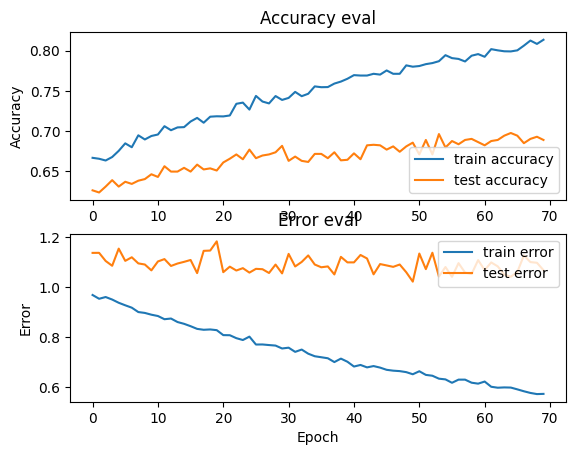

In [ ]:
plot_history(hist)

In [ ]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7043 - loss: 1.0218
Test accuracy: 0.6912294626235962


In [ ]:
def predict(model, X, y):
    X = X[np.newaxis,...]
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    print(f"Expected index: {y}, Predicted index: {predicted_index}")

In [ ]:
predict(model, X_test[10], y_test[10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Expected index: 6, Predicted index: [6]


In [ ]:
num_classes = len(set(y_train))  # или конкретное число, например 10
model.add(layers.Dense(num_classes, activation='softmax'))

In [ ]:
from keras import optimizers
input_shape = (X_train.shape[1], X_train.shape[2])  # (130, 13)

model = models.Sequential()
model.add(layers.LSTM(64, return_sequences=True, input_shape=input_shape))
model.add(layers.Dropout(0.3))
model.add(layers.GRU(64))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


In [ ]:
optimizer = optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=60,
                    batch_size=32)

Epoch 1/60
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.1138 - loss: 2.3235 - val_accuracy: 0.2697 - val_loss: 2.1759
Epoch 2/60
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.2205 - loss: 2.1749 - val_accuracy: 0.3451 - val_loss: 2.0240
Epoch 3/60
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.2896 - loss: 2.0460 - val_accuracy: 0.3611 - val_loss: 1.8657
Epoch 4/60
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3345 - loss: 1.9108 - val_accuracy: 0.3805 - val_loss: 1.7523
Epoch 5/60
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3581 - loss: 1.8131 - val_accuracy: 0.4052 - val_loss: 1.6601
Epoch 6/60
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3873 - loss: 1.7175 - val_accuracy: 0.4239 - val_loss: 1.5902
Epoch 7/60
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4113 - loss: 1.6457 - val_accuracy: 0.4486 - val_loss: 1.5391
Epoch 8/60
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4168 - loss: 1.5998 - val_accu

In [ ]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6258 - loss: 1.0971
Test accuracy: 0.6207448840141296


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

def build_crnn_attention(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2,2))(x)

    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2,2))(x)

    x = layers.TimeDistributed(layers.Flatten())(x)

    x = layers.Bidirectional(layers.GRU(128, return_sequences=True))(x)
    x = layers.Dropout(0.3)(x)

    scores  = layers.Dense(1)(x)                 # (batch, t, 1)
    weights = layers.Softmax(axis=1)(scores)     # (batch, t, 1)
    context = layers.Dot(axes=1)([weights, x])   # (batch, 1, features)
    context = layers.Flatten()(context)          # (batch, features)

    x = layers.Dense(128, activation='relu')(context)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

input_shape = (130, 64, 1)
num_classes = 10

model = build_crnn_attention(input_shape, num_classes)
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 130, 64,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 130, 64,   │        320 │ input_layer_11[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 130, 64,   │        128 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 65, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 65, 32,    │     18,496 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 65, 32,    │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 32, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 32, 1024)  │          0 │ max_pooling2d_9[… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 32, 256)   │    886,272 │ time_distributed… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 32, 256)   │          0 │ bidirectional_2[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 32, 1)     │        257 │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_2 (Softmax) │ (None, 32, 1)     │          0 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_2 (Dot)         │ (None, 1, 256)    │          0 │ softmax_2[0][0],  │
│                     │                   │            │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 256)       │          0 │ dot_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 128)       │     32,896 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 128)       │          0 │ dense_20[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 10)        │      1,290 │ dropout_23[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 939,915 (3.59 MB)

 Trainable params: 939,723 (3.58 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    inputs, targets,
    test_size=0.3,
    random_state=42,
    stratify=targets
)
print("X_train:", X_train.shape, "X_val:", X_val.shape)



X_train: (6990, 130, 13, 1) X_val: (2996, 130, 13, 1)


In [ ]:
model = build_crnn_attention(input_shape=(130,13,1), num_classes=10)
from tensorflow.keras import optimizers
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
    ]
)


Epoch 1/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.2828 - loss: 2.0004 - val_accuracy: 0.4860 - val_loss: 1.5046 - learning_rate: 1.0000e-04
Epoch 2/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5055 - loss: 1.4049 - val_accuracy: 0.5801 - val_loss: 1.1814 - learning_rate: 1.0000e-04
Epoch 3/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5624 - loss: 1.2176 - val_accuracy: 0.6435 - val_loss: 1.0274 - learning_rate: 1.0000e-04
Epoch 4/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6182 - loss: 1.0884 - val_accuracy: 0.6816 - val_loss: 0.9317 - learning_rate: 1.0000e-04
Epoch 5/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6607 - loss: 0.9792 - val_accuracy: 0.7093 - val_loss: 0.8623 - learning_rate: 1.0000e-04
Epoch 6/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.6954 - loss: 0.9023 - val_accuracy: 0.7156 - val_loss: 0.8299 - learning_rate: 1.0000e-04
Epoch 7/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - ac

In [ ]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9554 - loss: 0.1576
Test accuracy: 0.9547457098960876


In [ ]:
model.save('genre_crnn_attention.h5')
print("Модель сохранена в файл genre_crnn_attention.h5")

Модель сохранена в файл genre_crnn_attention.h5


In [ ]:
import json
import numpy as np
import librosa
from tensorflow.keras.models import load_model

model = load_model('genre_crnn_attention.h5')
with open('data.json', 'r') as f:
    metadata = json.load(f)
mapping = metadata['mapping']

SAMPLE_RATE   = 22050
DURATION      = 30
SAMPLES_TRACK = SAMPLE_RATE * DURATION
NUM_SEGMENTS  = 10
N_MFCC        = 13
N_FFT         = 2048
HOP_LENGTH    = 512

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Предсказанный жанр: reggae


In [ ]:
def extract_mfcc(file_path):
    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
    samples_per_segment = int(SAMPLES_TRACK / NUM_SEGMENTS)
    mfccs = []

    for s in range(NUM_SEGMENTS):
        start = s * samples_per_segment
        end   = start + samples_per_segment
        segment = signal[start:end]

        mfcc = librosa.feature.mfcc(
            y=segment,
            sr=sr,
            n_mfcc=N_MFCC,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH
        ).T

        if mfcc.shape[0] == int(np.ceil(samples_per_segment / HOP_LENGTH)):
            mfccs.append(mfcc)

    return np.array(mfccs)

In [ ]:
file_path = 'yamaika.wav'
mfcc_segments = extract_mfcc(file_path)

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(


In [ ]:
X = mfcc_segments[..., np.newaxis]

preds = model.predict(X)

mean_probs = np.mean(preds, axis=0)
predicted_index = np.argmax(mean_probs)
predicted_genre = mapping[predicted_index]

print(f"Предсказанный жанр: {predicted_genre}")

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
Предсказанный жанр: reggae


# Cнипет трека

In [ ]:
import torchaudio
import torch

def load_and_chunk_audio(path, chunk_duration_sec=5.0):
    waveform, sample_rate = torchaudio.load(path)
    total_samples = waveform.shape[1]
    chunk_size = int(sample_rate * chunk_duration_sec)

    chunks = []
    for start in range(0, total_samples - chunk_size + 1, chunk_size):
        end = start + chunk_size
        chunk = waveform[:, start:end]
        chunks.append((chunk, start / sample_rate))  # Сохраняем с временной меткой

    return chunks, sample_rate


In [ ]:
def compute_chunk_score(chunk):
    # RMS (энергия)
    energy = chunk.pow(2).mean().item()
    # Спектральная плотность (интереснее высокочастотные фрагменты)
    spec = torch.stft(chunk, n_fft=1024, return_complex=True)
    spectral_energy = spec.abs().mean().item()

    return energy + 0.5 * spectral_energy  # можно настраивать веса


In [ ]:
def find_best_snippet(audio_path, chunk_duration=5.0):
    chunks, sr = load_and_chunk_audio(audio_path, chunk_duration)

    scored_chunks = []
    for chunk, start_time in chunks:
        score = compute_chunk_score(chunk)
        scored_chunks.append((score, start_time))

    best_chunk = max(scored_chunks, key=lambda x: x[0])
    return best_chunk[1], best_chunk[1] + 2*chunk_duration  # start_time, end_time


In [ ]:
import torchaudio
def save_snippet(audio_path, start_sec, end_sec, output_path):
    waveform, sample_rate = torchaudio.load(audio_path)
    start_sample = int(start_sec * sample_rate)
    end_sample = int(end_sec * sample_rate)
    snippet = waveform[:, start_sample:end_sample]
    torchaudio.save(output_path, snippet, sample_rate)


In [ ]:
audio_path = "lady gaga.mp3"
start, end = find_best_snippet(audio_path, chunk_duration=10.0)
save_snippet(audio_path, start, end, "snippet.wav")
print(f"Сниппет: с {start:.2f} до {end:.2f} секунд")


Сниппет: с 190.00 до 210.00 секунд
